# **Importing Libraries**

In [1]:
# importing libraries
import torch
from torchvision import datasets
from torchvision import transforms
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Important libraries for creating models.
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict 
import torch.optim as optim
# Importing libraries for creating gifs
import matplotlib.animation as animation
import torchvision.utils as vutils
import imageio
import os

# **Downloading CelebA dataset from the following link**

In [2]:
!wget "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip"

--2021-01-10 10:15:38--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.113.229
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.113.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247694507 (236M) [application/zip]
Saving to: ‘processed-celeba-small.zip’

processed-celeba-sm 100%[===================>] 236.22M  7.19MB/s    in 35s     

2021-01-10 10:16:13 (6.78 MB/s) - ‘processed-celeba-small.zip’ saved [247694507/247694507]



In [3]:
!unzip "/content/processed-celeba-small.zip"

Streaming output truncated to the last 5000 lines.
  inflating: processed_celeba_small/celeba/New Folder With Items/052332.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg  
  inflating: 

# **Data Preproceccing**

In [4]:
data_dir = '/content/processed_celeba_small/celeba'

In [5]:
def fn_Dataloader(batch_size, image_size, data_dir='/content/processed_celeba_small/celeba'):#real name get_dataloader
  """
  batch_size : The size of each batch(the number of images in a batch).
  img_size: The square size of the image data (x, y).
  data_dir: Directory where image data is located
  Return Data that shuffles and batches tensor images.
  """
  data_transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
  train_data = datasets.ImageFolder(data_dir, transform= data_transform)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0 )

  return train_loader


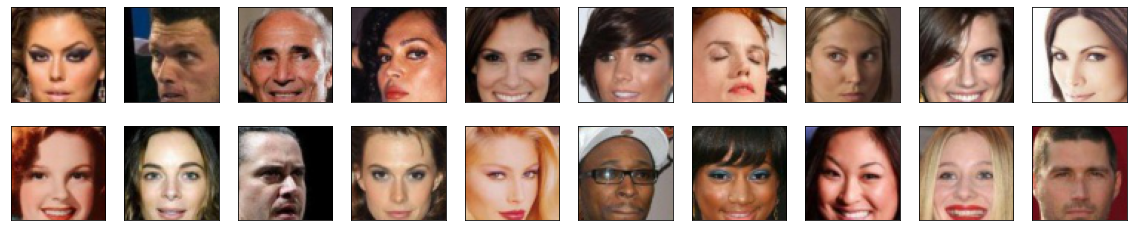

In [6]:
# Just a small experiment to make sure that everything is okay.

batch_size = 128
img_size = 64

# Call your function and get a dataloader
celeba_train_loader = fn_Dataloader(batch_size, img_size)


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

# Rescalling training images:  
  The output of a tanh activated generator will contain pixel values in a range from -1 to 1, 
  and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range of 0 to 1.)
  
  t_image : training image.

  f_range : feature range.

In [7]:
def make_scale(t_img, f_range=(-1, 1)):
  #real name scale
  min, max = f_range
  t_img = t_img * (max - min) + min

  return t_img


In [8]:
# Checking if scaling has occured
img = images[0]
scaled_image = make_scale(img)
print('Min: ', scaled_image.min())
print('Max: ', scaled_image.max())

Min:  tensor(-1.)
Max:  tensor(1.)


#**Defining** **Model**
A GAN is comprised of 2 neural networks:


*   **Genarator** : generates fake images from random vectors

> Generator Inputs : vectors of some length z_size

> Generator Outputs : images of shape 64x64x3


*   **Discriminator**: Tries to distinguish between real and fake data


> Discriminator Inputs : 64x64x3 tensor images


> Discriminator Outputs : A single value that will indicate whether a given image is real or fake






# **Creating Genarator Class**

In [9]:

class Generator(nn.Module):

    def __init__(self, z_dim, hidden_dim):
        
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
          # Build the neural network
        self.generator = nn.Sequential(
            self.make_generator_block( z_dim, hidden_dim * 8, stride = 1, padding= 0 ),
            self.make_generator_block( hidden_dim * 8, hidden_dim * 4),
            self.make_generator_block( hidden_dim * 4, hidden_dim * 2),
            self.make_generator_block( hidden_dim * 2, hidden_dim),
            self.make_generator_block( hidden_dim , 3,final_layer=True),)        
          
    def make_generator_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding = 1, bias = False, final_layer=False):
        # Build the neural block
        if not final_layer:
            return nn.Sequential( nn.ConvTranspose2d(input_channels, output_channels, kernel_size,  stride, padding , bias),                                        
                    nn.BatchNorm2d(output_channels),
                    nn.ReLU(inplace=True),)                               
        else: 
            return nn.Sequential(nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias),
                nn.Tanh(),)
                                              
                  
    def forward(self, x):    
        out = self.generator(x)
        return out
print(Generator(100,64))

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): 

# **Creating Discriminator Class**

In [10]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            self.make_discriminator_block( 3, hidden_dim, first_layer=True),
            self.make_discriminator_block( hidden_dim, hidden_dim * 2),
            self.make_discriminator_block( hidden_dim * 2, hidden_dim * 4),
            self.make_discriminator_block( hidden_dim * 4, hidden_dim * 8),
            self.make_discriminator_block( hidden_dim * 8 , 1,final_layer=True),)
    
    def make_discriminator_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding = 1,dilation=True,groups=1, bias = False, first_layer=False, final_layer=False):
        if (not(final_layer or first_layer)):
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding,dilation, groups, bias),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True))
            
        elif first_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, dilation, groups, bias),
                nn.LeakyReLU(0.2, inplace=True))            
           
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels,kernel_size,stride=1,padding =0,dilation=True, groups=1, bias=False)
                )
            
    def forward(self, x):

        out = self.discriminator(x)
        return out
print(Discriminator(64))
 

Discriminator(
  (discriminator): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=Tr

# **Initail Weights** 



In [11]:
from torch.nn import init
def initial_weights_normal(network):
    classname = network.__class__.__name__
    if hasattr(network, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(network.weight.data, 0.0, 0.02)
        
        if hasattr(network, 'bias') and network.bias is not None:
            init.constant_(network.bias.data, 0.0)
                
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(network.weight.data, 1.0, 0.02)
        init.constant_(network.bias.data, 0.0)


# **Build Network**

In [12]:
def build_network(d_conv_dim, g_conv_dim, z_size, verbose = False):
    D = Discriminator(d_conv_dim)
    G = Generator(z_dim=z_size, hidden_dim=g_conv_dim)
    D.apply(initial_weights_normal)
    G.apply(initial_weights_normal)
    if verbose:
        print(D)
        print()
        print(G)
    return D, G


In [13]:
D, G = build_network(64, 64, 100, verbose = True)

Discriminator(
  (discriminator): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=Tr

# **Apply GPU for Training**

In [14]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


#**Generator and Discriminator Losses**
-   **real_loss**: Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits.
       
-   **fake_loss**: Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits.
       

In [15]:
def real_loss(D_out, smooth = False):

    _batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(_batch_size)*0.9
    else:
        labels = torch.ones(_batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):

    _batch_size = D_out.size(0)
    labels = torch.zeros(_batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss 

# **Training Functions of Genarator and Discriminator**

In [16]:
def train(D, G, n_epochs,d_optimizer, g_optimizer, batch_size, z_size=100, img_size=64 ,save_samples=True):
    
    
    celeba_train_loader = fn_Dataloader(batch_size, img_size)
    
    # used for print_msg 
    epoch_len = len(str(n_epochs))
    batches = len(celeba_train_loader)
    batches_len = len(str(batches))
    # print 10 times per epoch
    print_every = batches // 10
    
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []
    avg_losses = []
    d_losses = []
    g_losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size = 64
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size, 1, 1))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(1, n_epochs + 1):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            _batch_size = real_images.size(0)
            real_images = make_scale(real_images)

            
            #*********************************************TRAIN THE NETWORKS*************************************
            
            
            d_optimizer.zero_grad()          
            
            # 1. Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(_batch_size, z_size, 1, 1))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(_batch_size, z_size, 1, 1))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            
            # Add first loss before training starts
            if batch_i == 0 and epoch == 1:
                losses.append((d_loss.item(), g_loss.item()))
            
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # record loss
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            
            
            #******************************************END OF training part*********************************
         

            # Print some loss stats
            if batch_i % print_every == 0:
                # calculate average loss
                d_loss_avg = np.average(d_losses)
                g_loss_avg = np.average(g_losses)
                # print discriminator and generator loss
                print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}]' +
                             f'[{batch_i+1:>{batches_len}}/{batches:>{batches_len}}] | ' +
                             f'd_loss: {d_loss_avg:.5f} | ' +
                             f'g_loss: {g_loss_avg:.5f}')
                print(print_msg)
                
        ## AFTER EACH EPOCH##
        
        # calculate average loss over an epoch
        d_loss_avg = np.average(d_losses)
        g_loss_avg = np.average(g_losses)
        losses.append((d_loss_avg, g_loss_avg))     
        
        if save_samples:
            # generate and save sample, fake images
            G.eval() # for generating samples
            samples_z = G(fixed_z)
            samples.append(samples_z)
            G.train() # back to training mode
        
        # reset, only track loss per epoch fro average
        d_losses = []
        g_losses = []
    
    
    if save_samples:
        _lr = d_optimizer.param_groups[0]['lr']
        _beta1 = g_optimizer.param_groups[0]['betas'][0]
        # Save training generator samples
        with open(f'/content/training_samples/train_samples_lr_{_lr:.4f}_beta1_{_beta1:.2f}_bs_{batch_size}.pkl', 'wb') as f:
            pkl.dump(samples, f)
    
    # finally return losses
    _lr = d_optimizer.param_groups[0]['lr']
    _beta1 = g_optimizer.param_groups[0]['betas'][0]
    title = f'lr_{_lr:.4f}_beta1_{_beta1:.2f}_bs_{batch_size}'
    
    return title, losses

# **Set Hyperparameters**

In [17]:
# Define hyperparameters
img_s = 64

d_hidden_dim = 64
g_hidden_dim = 64
z_s = 100

beta2 = 0.999 # default value
# set number of epochs 
n_epochs = 20
# set batch size
batch_s = 32
# set learning rate
lr = 0.0002
# set beta1
beta1 = 0.5

# **Train Model**

In [18]:
D, G = build_network(d_hidden_dim, g_hidden_dim, z_s)
print(f'lr {lr:.5f}, beta1 {beta1:.5f}, bs {batch_s}')
# Create optimizers for the discriminator and generator
d_opt = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_opt = optim.Adam(G.parameters(), lr, [beta1, beta2])
title , loss = train(D, G, n_epochs, d_opt, g_opt, batch_s,z_size=z_s ,img_size=img_s, save_samples=True)

# save loss log
with open("/content/training_samples/" + title + "_loss_log.pkl", 'wb') as f:
    pkl.dump(loss, f)

lr 0.00020, beta1 0.50000, bs 32
[ 1/20][   1/1792] | d_loss: 1.68213 | g_loss: 4.18930
[ 1/20][ 180/1792] | d_loss: 0.77334 | g_loss: 8.34946
[ 1/20][ 359/1792] | d_loss: 0.74761 | g_loss: 6.95474
[ 1/20][ 538/1792] | d_loss: 0.76729 | g_loss: 6.10243
[ 1/20][ 717/1792] | d_loss: 0.76474 | g_loss: 5.70427
[ 1/20][ 896/1792] | d_loss: 0.75868 | g_loss: 5.49349
[ 1/20][1075/1792] | d_loss: 0.75732 | g_loss: 5.32819
[ 1/20][1254/1792] | d_loss: 0.74818 | g_loss: 5.15741
[ 1/20][1433/1792] | d_loss: 0.75309 | g_loss: 5.01073
[ 1/20][1612/1792] | d_loss: 0.75395 | g_loss: 4.87215
[ 1/20][1791/1792] | d_loss: 0.75778 | g_loss: 4.73398
[ 2/20][   1/1792] | d_loss: 0.68547 | g_loss: 3.27046
[ 2/20][ 180/1792] | d_loss: 0.79913 | g_loss: 3.47472
[ 2/20][ 359/1792] | d_loss: 0.79166 | g_loss: 3.40054
[ 2/20][ 538/1792] | d_loss: 0.78681 | g_loss: 3.36062
[ 2/20][ 717/1792] | d_loss: 0.79206 | g_loss: 3.33029
[ 2/20][ 896/1792] | d_loss: 0.79907 | g_loss: 3.29870
[ 2/20][1075/1792] | d_loss: 0.8

# **Visualize G_loss and D_loss**

In [19]:
# Loss plot function
def plot_loss(training_loss, title):
    # visualize the loss as the network trained
    plt.figure(figsize=(8,5))

    plt.plot(np.array(training_loss).T[0], label='Discriminator', alpha=0.5)
    plt.plot(np.array(training_loss).T[1], label='Generator', alpha=0.5)
    plt.ylim(0, 6) # consistent scale
    plt.grid(True)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('/content/plots/' + title + '.png')
    plt.show()

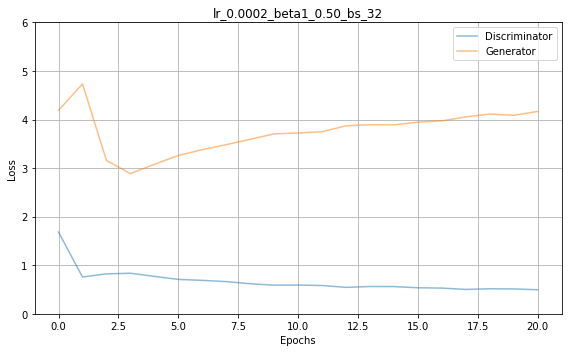

In [20]:
# read_file
folder = '/content/training_samples/'
title = 'lr_0.0002_beta1_0.50_bs_32'

with open(folder + title + '_loss_log.pkl', 'rb') as f:
    training_loss = pkl.load(f)

plot_loss(training_loss, title)

In [21]:
def generate_gif(name,img_grid,epochs):
    # create gif
    ims = []

    for epoch_n, img in enumerate(img_grid):
        fig = plt.figure(figsize=(10,10))
        plt.axis('off')
        title = 'Epoch {0}'.format(epoch_n+1)
        fig.text(0.48, 0.1, title, ha='left',fontsize=12)
        plt.axis(adjustable='box-forced')
        plt.imshow(np.transpose(img.cpu(),(1,2,0)), interpolation='nearest')
        fig.canvas.draw() 
        # save to numpy array
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        if not os.path.exists('Temp/'):
            os.mkdir('Temp/')
        img_loc = 'Temp/' + 'temp_image_{:d}'.format(epoch_n+1) + '.jpg'
        plt.savefig(img_loc, bbox_inches='tight')

        ims.append(imageio.imread(img_loc))

        os.remove(img_loc)

        plt.close()

    imageio.mimsave(name + '_epochs_{:d}'.format(epochs) + '.gif', ims, fps=2)

In [22]:
with open('/content/training_samples/train_samples_lr_0.0002_beta1_0.50_bs_32.pkl', 'rb') as f:
    samples = pkl.load(f)

In [23]:
img_grid = []
n_epochs = 20
for img in samples:
    img_grid.append(vutils.make_grid(img.detach(), padding=2, normalize=True))

generate_gif("gifs/lr_0.0002_beta1_0.50_bs_32",img_grid,n_epochs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


In [24]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((64,64,3)))

In [25]:
with open('/content/training_samples/train_samples_lr_0.0002_beta1_0.50_bs_32.pkl', 'rb') as f:
    samples = pkl.load(f)

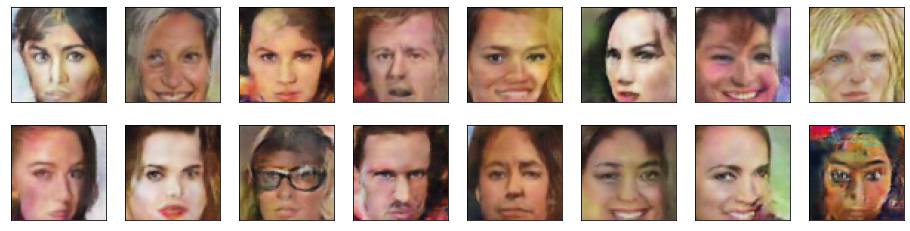

In [26]:
_ = view_samples(-1, samples)